# Basic Imports

In [1]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

NameError: name 'teacher' is not defined

# Create teacher and student model

Both:

In [3]:
teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Only the student or teacher:

(setting student=False will only return a single model)

In [2]:
teacher, sampler_teacher = create_models(config_path, model_path, student=False)
# student, sampler_student = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [7]:
get_fid(teacher, sampler_teacher, num_imgs=100, name="test", instance = 1, steps=[32, 16, 4])

[192.34653881656635, 196.09820962588051, 214.45794731561983]

In [ ]:
# 25, 32 30 28
[280.95998454461585, 265.6562646638485, 259.42498028791465]
[268.2475327621082, 253.47468063140076, 269.11813078828123]
[285.0040415728024, 286.4392934046366, 281.6250182169074]

# 50, 32 30 28
[222.9160995145525, 238.06096378967118, 234.90504309116406]
[231.57566777727834, 244.8973449916839, 222.32638319321904]

#100, 32 30 28
[188.99371256139426, 202.30040796173162, 192.7012391879187]
[193.67558037132363, 196.20156128265342, 208.71124492296556]

# Generating and saving images at various steps for FID

In [ ]:
save_images(teacher, sampler_teacher, 50000, "original", [64, 32, 16, 8, 4, 2, 1])

# Comparing FID

In [6]:
# from torchvision import datasets, transforms
# from pytorch_fid import fid_score

# # Load real images
# real_images = datasets.ImageFolder(root=f'{cwd}/cin_1000', transform=transforms.ToTensor())

# # Load generated images
# generated_images = datasets.ImageFolder(root=f'{cwd}/saved_images/original/16', transform=transforms.ToTensor())

# # Compute FID score
# fid_score(real_images, generated_images)


python -m pytorch_fid C:/val_saved/real_fid_both.npz C:/Diffusion_Thesis/cin_256/saved_images/original/64 --device cuda:0 --dims 2048

SyntaxError: invalid syntax (3120201641.py, line 14)

In [7]:
from pytorch_fid import fid_score
fid_score.calculate_fid_given_paths(["C:/val_saved/real_fid_both.npz", "C:/Diffusion_Thesis/cin_256/saved_images/original/64"],batch_size=64,device="cuda", dims=2048 )

100%|██████████| 301/301 [00:51<00:00,  5.80it/s]


AssertionError: Training and test mean vectors have different lengths

# Loading trained student as teacher

In [ ]:
# model_path_test = f"{cwd}/data/trained_models/10/student_intermediate_15.pt"
# teacher, sampler_teacher, optimizer, scheduler = load_trained(model_path_test, config_path)

## Generating WITHOUT intermediates saved

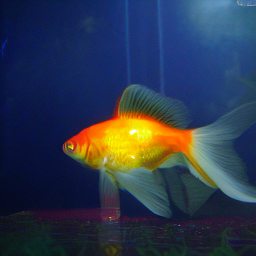

In [4]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=32, scale=3, keep_intermediates=False)
img

In [16]:
from torchvision.utils import return_image
a = return_image(x_T_copy, fp="test")

a = torch.tensor(a, dtype=torch.uint8)

TypeError: an integer is required (got type Image)

In [14]:
from torchmetrics.image.fid import FrechetInceptionDistance 
fid = FrechetInceptionDistance(feature=64)
fid.update(a, real=False)
fid.compute()

ValueError: Expecting image as torch.Tensor with dtype=torch.uint8

# Generating WITH intermediates saved

In [7]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

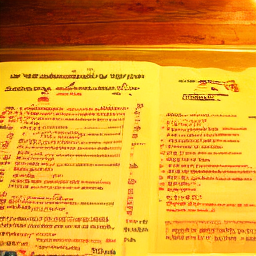

In [14]:
latent_to_img(teacher, intermediates[125])

# Creating a dataset

In [4]:
# dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
# dataset_name = "teacher_128.pt"
# make_dataset(teacher, sampler_teacher, 501, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:26:03<00:00, 10.33s/it]


# Training student from teacher directly

In [2]:
# wandb_session = wandb_log(name="test_loss", lr=1e-8, model=student, tags=["test"], notes="Just a test")

optimizer, scheduler = get_optimizer(sampler_student, iterations=20*20)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=20, generations=1, early_stop=True, session=None)

# wandb.finish()

NameError: name 'sampler_student' is not defined

In [27]:
at = 0.001
st = 0.999
np.exp((np.log(((at ) / (st )))))

0.0010010010010010006

Extra, quick comparison:

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[8, 10, 12, 32])
images

In [1]:
from util import *
import wandb
from importlib import reload



cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"


lr = 0.000001
generations =  16
steps = 8


teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

# wandb_session = wandb_log(name="test_loss", lr=1e-8, model=student, tags=["test"], notes="Just a test")

session = None

optimizer, scheduler = get_optimizer(sampler_student, iterations=steps*generations, lr=lr)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=steps, generations=generations, early_stop=False, session=session)

images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[16])

# wandb.finish()

del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

images


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


  0%|          | 0/16 [00:01<?, ?it/s]


ValueError: not enough values to unpack (expected 5, got 4)

In [5]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[8, 10, 12, 32])
images

tensor([0.0387, 0.0548, 0.0672, 0.0777, 0.0869, 0.0953, 0.1030, 0.1103, 0.1170,
        0.1235, 0.1296, 0.1355, 0.1412, 0.1466, 0.1519, 0.1570, 0.1620, 0.1669,
        0.1716, 0.1762, 0.1807, 0.1851, 0.1894, 0.1937, 0.1978, 0.2019, 0.2060,
        0.2099, 0.2138, 0.2176, 0.2214, 0.2252], device='cuda:0')

In [4]:
student.alphas_cumprod[32]

tensor(0.9476, device='cuda:0')

In [2]:
images, grid = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 6, 8, 10, 16, 20, 32, 64, 128], prompt=992)
images

NameError: name 'teacher' is not defined

In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

# Train student from pre-generated teacher dataset

In [3]:
data_dir = f"{cwd}/data/pre_generated/teacher_128/"
datasets = os.listdir(data_dir)

In [ ]:
notes = """This is a serious attempt to distill the 128 step original teacher into a 64 step student, trained on 32000 instances"""
wandb_session = wandb_log(name="Train_student_on_128_pretrained", lr=0.00000001, model=student, tags=["distillation"], notes=notes)

optimizer, scheduler = get_optimizer(sampler_student, iterations=64*500)

dataset = torch.load(data_dir + datasets[0])
train_student_from_dataset(student, sampler_student, dataset, 64, optimizer, scheduler, early_stop=True, session=wandb_session)

wandb.finish()

save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

# Save and Loading trained models

In [ ]:
save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

In [ ]:
path = f"{cwd}/data/trained_models/64/student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = load_trained(path, config_path)

# Direct Comparison

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32, 64, 128])
images



In [3]:
2 % 1

0

# Distillation Loop (allnighter)

In [1]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom_pc.ipynb"
ddim_steps = [64]
run_name = "unconditional"
generations = 1000
lr=0.00001
config = f"{cwd}/models/configs/cin256-v2-custom.yaml"
original_model_path = f"{cwd}/models/cin256_original.ckpt"
distill(ddim_steps, generations, run_name, config, original_model_path, lr=lr, start_trained=False)

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


^C
Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc
c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Cin_256_custom_pc.ipynb.


Loading New Student and teacher: 64


# Comparing trained student with Teacher


In [1]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"
teacher, sampler_teacher = create_models(config_path, model_path, student=False)
path = "C:\Diffusion_Thesis\cin_256\data\success\\1-8_25000\\4\\student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = load_trained(path, config_path)


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [2]:
compare_fid_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[16], prompt=992)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

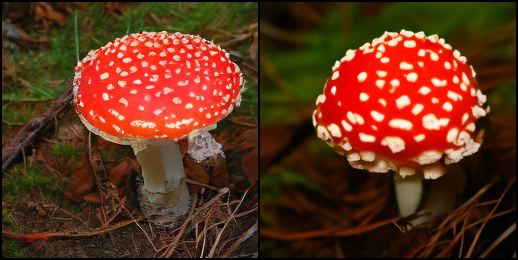

In [3]:
# images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[64, 32, 16, 8, 4, 2, 1], prompt=992)
# images

# images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[64, 32, 16, 8,  4, 2, 1], prompt=992)
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[16], prompt=992)
images

In [59]:
from torchmetrics.image.fid import FrechetInceptionDistance 
fid = FrechetInceptionDistance(feature=64)
img = torch.tensor(_[:, 259:518, :].reshape((1, 2, 3, 4)).astype(np.uint8))
fid.update(img, real=False)
print(fid.compute())
# Image.fromarray(_[:, 259:518, :])

ValueError: cannot reshape array of size 202020 into shape (1,2,3,4)

In [46]:
_[:, :256, :].shape



(260, 256, 3)

In [25]:
_.shape

(260, 518, 3)

# Self-Distillation

In [1]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"
teacher, sampler_teacher = create_models(config_path, model_path, student=False)
original, sampler_original = create_models(config_path, model_path, student=False)



c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [2]:
steps = 32
generations = 100000
model_generations = generations // steps
lr = 0.00000001 
decrease_steps = True
optimizer, scheduler = get_optimizer(sampler_teacher, iterations=generations, lr=lr)

run_name = f"CSD-{steps}-{lr}-{generations}"
notes = f"""Self-distilling the {steps} step original teacher into a smaller continuous model,"""
wandb_session = wandb_log(name=run_name, lr=lr, model=teacher, tags=["continuous self-distillation", run_name], notes=notes)
wandb.run.log_code(".")
session = wandb_session
step_scheduler = "deterministic"
# session=None

try:
    self_distillation(teacher, sampler_teacher, original, sampler_original, optimizer, scheduler, session=session, 
                      steps=steps, generations=model_generations, early_stop=False, 
                      run_name=run_name, decrease_steps=decrease_steps, step_scheduler=step_scheduler)
except Exception as e:
    del teacher, sampler_teacher, optimizer, scheduler
    torch.cuda.empty_cache()
    print(traceback.format_exc())

wandb: Currently logged in as: pmobiluss. Use `wandb login --relogin` to force relogin


  1%|          | 19/3125 [10:36<28:52:52, 33.47s/it, epoch_loss=0.0035]


KeyboardInterrupt: 

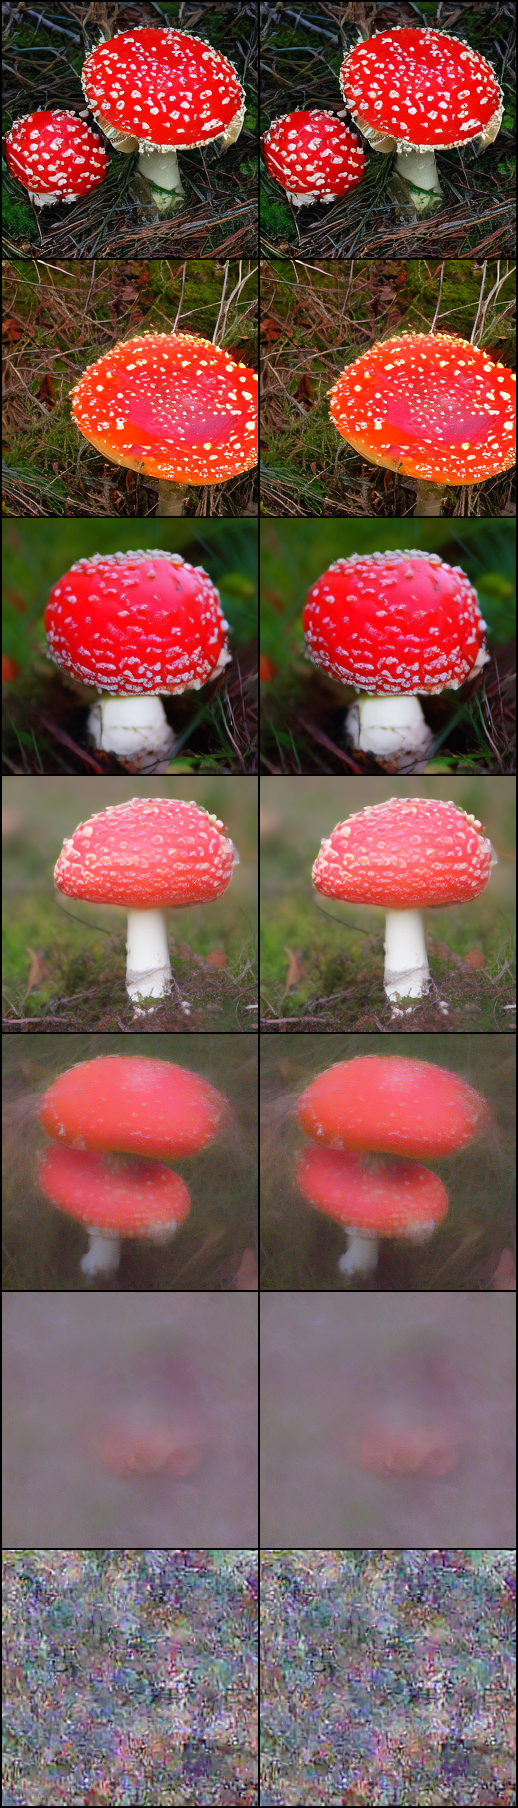

In [3]:
images, _ = compare_teacher_student(original, sampler_original, teacher, sampler_teacher, steps=[64, 32, 16, 8,  4, 2, 1], prompt=992)
images

In [4]:
import math
math.floor(math.log(64)/math.log(2))

6

In [3]:
for i in range(0):
    print(i)

In [5]:
import math
generations = 128
steps = 32
halvings = math.floor(math.log(steps)/math.log(2)) - 1
halvings

4

In [11]:
halving_steps = []
for i in range(1, halvings+1):
    halving_steps.append(int(generations * (1 / (halvings + 2)) * i))

halving_steps

[21, 42, 64, 85]